The Enron scandal was one of the biggest corporate fraud cases in history. Enron, an American energy company, collapsed in 2001 due to accounting fraud, leading to its bankruptcy and the dissolution of its auditing firm, Arthur Andersen.

Key Points:

- Fraudulent Accounting: Enron executives used mark-to-market accounting and special purpose entities (SPEs) to hide billions in debt while inflating profits.
- Stock Price Manipulation: At its peak, Enron's stock traded at \$90.75, but
 after  the  fraud  was  exposed,  it  plummeted  to  \$0.26. bold text

- Legal Consequences: Several executives, including Jeffrey Skilling and Andrew Fastow, were convicted. Kenneth Lay, Enron's founder, was also convicted but passed away before sentencing.
- Impact on Regulations: The scandal led to the creation of the Sarbanes-Oxley Act (2002), which imposed stricter financial reporting and auditing regulations.



- The Enron email dataset includes more than 500,000 emails from 150 employees of Enron, collected during the investigation into the company's collapse.
- After extraction, the dataset is typically stored in a directory structure like:
- Each employee has folders containing raw email files in plain text (.txt) format. We need to parse these emails to extract useful fields like sender, recipient, subject, and body



#  Work Plan: Enron Email Clustering for Fraud Detection

---

## 1. **Project Setup**

### 1.1 Objectives

* Detect hidden patterns in Enron emails.
* Identify potential anomalies or fraud-like behavior.
* Explore metadata and email content jointly.

### 1.2 Environment Setup

* Set up Python environment (Colab or local Jupyter)
* Import necessary libraries.


---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from wordcloud import WordCloud, STOPWORDS
from datetime import datetime

import re
import string
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
# from sklearn.neighbors import NearestNeighbors
# from sklearn.cluster import DBSCAN
import cudf
import cupy as cp
from cuml.neighbors import NearestNeighbors

from datetime import datetime

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

## 2. **Data Understanding & Cleaning**

### 2.1 Load Data

* Load the Enron email dataset into a pandas DataFrame.

### 2.2 Initial Exploration

* Inspect column types and sample rows.
* Check for missing or inconsistent values.

### 2.3 Clean and Standardize Fields

* Clean sender names in the `'X-From'` column
* Keep only meaningful columns `'content'`, `'From'`, `'To'`, `'Cc'`, `'Date'`, `'Subject'`.
* Remove or fill missing fields as needed.

---


In [3]:
emails = pd.read_csv("/content/drive/MyDrive/fraudulent/enron_email/emails_cleaned.csv", index_col=0)
emails.info()

<ipython-input-3-78d0a7c72507>:1: DtypeWarning: Columns (8,15) have mixed types. Specify dtype option on import or set low_memory=False.
  emails = pd.read_csv("/content/drive/MyDrive/fraudulent/enron_email/emails_cleaned.csv", index_col=0)


<class 'pandas.core.frame.DataFrame'>
Index: 517398 entries, 0 to 517400
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   content                    517398 non-null  object
 1   Message-ID                 517398 non-null  object
 2   Date                       517398 non-null  object
 3   From                       517398 non-null  object
 4   To                         495553 non-null  object
 5   Subject                    498118 non-null  object
 6   Cc                         127883 non-null  object
 7   Mime-Version               517398 non-null  object
 8   Content-Type               517398 non-null  object
 9   Content-Transfer-Encoding  517398 non-null  object
 10  Bcc                        127883 non-null  object
 11  X-From                     517398 non-null  object
 12  X-To                       508247 non-null  object
 13  X-cc                       128886 non-null  objec

In [4]:
emails

,content,Message-ID,Date,From,To,Subject,Cc,Mime-Version,Content-Type,Content-Transfer-Encoding,Bcc,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName
0,"ok, whatever",<5633964.1075841410781.JavaMail.evans@thyme,"Tue, 24 Apr 2001 19:24:00 -0700 (PDT",vladi.pimenov@enron.co,natalie.bondareva@enron.co,Re: go EES!!,NaN,1.0,text/plain; charset=us-asci,7bi,NaN,Vladi Pimeno,Natalie Bondareva <Natalie Bondareva/HOU/EES@EES,NaN,NaN,"\ExMerge - Pimenov, Vladi\'Sent Mai",PIMENOV-,vladi pimenov 6-26-02.PST
1,Bush names businessmen to Pentagon civilian po...,<369679.1075841410758.JavaMail.evans@thyme,"Tue, 24 Apr 2001 19:09:00 -0700 (PDT",vladi.pimenov@enron.co,nbondare@enron.co,go EES!!,NaN,1.0,text/plain; charset=us-asci,7bi,NaN,Vladi Pimeno,nbondare <nbondare@enron.com,NaN,NaN,"\ExMerge - Pimenov, Vladi\'Sent Mai",PIMENOV-,vladi pimenov 6-26-02.PST
2,"Patrick,\n\nwith regard to the deal we did on ...",<18938798.1075841410826.JavaMail.evans@thyme,"Mon, 14 May 2001 14:19:00 -0700 (PDT",vladi.pimenov@enron.co,patrick.mulvany@enron.co,Re: physical trad,NaN,1.0,text/plain; charset=us-asci,7bi,NaN,Vladi Pimeno,Patrick Mulvany <Patrick Mulvany/ENRON@enronXgate,NaN,NaN,"\ExMerge - Pimenov, Vladi\'Sent Mai",PIMENOV-,vladi pimenov 6-26-02.PST
3,"Patrick,\n\nwe fixed the deal. Thank you for b...",<7037757.1075841410849.JavaMail.evans@thyme,"Wed, 16 May 2001 18:28:00 -0700 (PDT",vladi.pimenov@enron.co,patrick.mulvany@enron.co,Re: physical deal #78391,NaN,1.0,text/plain; charset=us-asci,7bi,NaN,Vladi Pimeno,Patrick Mulvany <Patrick Mulvany/ENRON@enronXgate,NaN,NaN,"\ExMerge - Pimenov, Vladi\'Sent Mai",PIMENOV-,vladi pimenov 6-26-02.PST
4,"Rogers Herndon - eto tot muzhiuk, kotoriy el d...",<32990561.1075841410804.JavaMail.evans@thyme,"Fri, 4 May 2001 11:37:00 -0700 (PDT",vladi.pimenov@enron.co,nbondare@enron.co,Organization Announcemen,NaN,1.0,text/plain; charset=us-asci,7bi,NaN,Vladi Pimeno,nbondare <nbondare@enron.com,NaN,NaN,"\ExMerge - Pimenov, Vladi\'Sent Mai",PIMENOV-,vladi pimenov 6-26-02.PST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517396,CGoering@nyiso.com writes to the NYISO_TECH_EX...,<18982546.1075857923491.JavaMail.evans@thyme,"Wed, 16 May 2001 08:40:00 -0700 (PDT",owner-nyiso_tech_exchange@lists.thebiz.ne,tie_list_server.nyiso@nyiso.co,Price Reservations 15 May 2001 Real-Time Marke...,NaN,1.,text/plain; charset=us-asci,7bi,NaN,owner-nyiso_tech_exchange@lists.thebiz.ne,TIE_List_Server.NYISO@nyiso.co,NaN,NaN,\Larry_Campbell_Jun2001\Notes Folders\Notes inbo,Campbell-,lcampbel.nsf
517397,"Gentlemen,\n\nWith the company moving forward ...",<9102256.1075851924890.JavaMail.evans@thyme,"Mon, 2 Oct 2000 14:59:00 -0700 (PDT",mike.riedel@enron.co,"randy.rice@enron.com, dave.odneal@enron.com, k...",Environmental Service,"butch.russell@enron.com, leo.nichols@enron.com...",1.,text/plain; charset=us-asci,7bi,"butch.russell@enron.com, leo.nichols@enron.com...",Mike Riede,"Randy Rice, Dave Odneal, Ken Earl, Rich Jolly,...","Butch Russell, Leo Nichols, Rick Loveless, Ron...",NaN,\Larry_Campbell_Nov2001_1\Notes Folders\Southw...,CAMPBELL-,lcampbe.nsf
517398,3AC0561,<13458410.1075859283407.JavaMail.evans@thyme,"Thu, 29 Nov 2001 10:43:58 -0800 (PST",larry.campbell@enron.co,NaN,Byron Ranc,NaN,1.,text/plain; charset=us-asci,7bi,NaN,"Campbell, Larry </O=ENRON/OU=NA/CN=RECIPIENTS/...",NaN,NaN,NaN,"\Larry_Campbell_Jan2002_2\Campbell, Larry\Contact",Campbell-,lcampbe (Non-Privileged).pst
517399,Migrated,<24722632.1075859283299.JavaMail.evans@thyme,"Thu, 29 Nov 2001 10:10:58 -0800 (PST",larry.campbell@enron.co,NaN,Roger Osbor,NaN,1.,text/plain; charset=us-asci,7bi,NaN,"Campbell, Larry </O=ENRON/OU=NA/CN=RECIPIENTS/...",NaN,NaN,NaN,"\Larry_Campbell_Jan2002_2\Campbell, Larry\Contact",Campbell-,lcampbe (Non-Privileged).pst


In [5]:
emails["content"]

,content
0,"ok, whatever"
1,Bush names businessmen to Pentagon civilian po...
2,"Patrick,\n\nwith regard to the deal we did on ..."
3,"Patrick,\n\nwe fixed the deal. Thank you for b..."
4,"Rogers Herndon - eto tot muzhiuk, kotoriy el d..."
...,...
517396,CGoering@nyiso.com writes to the NYISO_TECH_EX...
517397,"Gentlemen,\n\nWith the company moving forward ..."
517398,3AC0561
517399,Migrated


In [6]:
emails["content"][2]

'Patrick,\n\nwith regard to the deal we did on ICE, their confirmation is right. It should be Gas Daily TETCO M3, not Z6. Please let me know if you need any additional information.\n\nVladi Pimenov\n\nx37625'

In [7]:
emails.iloc[2, :]

,2
content,"Patrick,\n\nwith regard to the deal we did on ..."
Message-ID,<18938798.1075841410826.JavaMail.evans@thyme
Date,"Mon, 14 May 2001 14:19:00 -0700 (PDT"
From,vladi.pimenov@enron.co
To,patrick.mulvany@enron.co
Subject,Re: physical trad
Cc,NaN
Mime-Version,1.0
Content-Type,text/plain; charset=us-asci
Content-Transfer-Encoding,7bi


In [8]:
# Count unique senders
print("Senders in dataset:\n", emails['X-From'].dropna().unique())
print("\nNumber of senders:", emails['X-From'].nunique())
sender_counts = emails['X-From'].value_counts()
print("\nCount of sender:\n", sender_counts[300:320])

Senders in dataset:
 ['Vladi Pimeno'
 'Chavez, Alejandra </O=ENRON/OU=NA/CN=RECIPIENTS/CN=ACHAVEZ2'
 'Rabon, Chance </O=ENRON/OU=NA/CN=RECIPIENTS/CN=CRABON' ...
 'ClickAtHome and Community Relations- <ClickAtHome and Community Relations-@Enron'
 'Janet Thwaits  <janet@thwaits.com'
 '"1-800-FLOWERS.COM" <1800Flowers.90264496@s2u2.com']

Number of senders: 27984

Count of sender:
 X-From
Cathy Phillip                                                   217
Colleen Sulliva                                                 217
Ina Range                                                       215
Becky Spence                                                    213
Mims, Patrice L. </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PMIMS         212
Brennan, Lorna </O=ENRON/OU=NA/CN=RECIPIENTS/CN=LBRENNA         212
Lexi Elliot                                                     210
Espinoza, Veronica </O=ENRON/OU=NA/CN=RECIPIENTS/CN=VESPINO     210
Tracy Geaccon                                                   209

The dataset was collected from 150 employees of Enron, but there are far more unique senders, some of which due to the inconsistencies in formatting.
There are mixed formats, and other problems like:

Name with email (sometimes partial): "Greg Elliott <gelliott@industrialinfo.com>@ENRO"

Name with Exchange-style path: "Mims, Patrice L. </O=ENRON/OU=NA/CN=RECIPIENTS/CN=PMIMS>"

In [9]:
# Create cleaner for the sender column

def extract_clean_name(xfrom):
    if pd.isnull(xfrom):
        return None

    # Remove any Exchange identifiers or weird endings
    xfrom = re.sub(r'</O=.*', '', xfrom).strip()

    # Remove partial or broken email angle brackets
    xfrom = re.sub(r'<.*', '', xfrom).strip()

    # Remove any trailing domain parts like @ENRON
    xfrom = re.sub(r'@.*', '', xfrom).strip()

    # Strip outer quotes and whitespace
    xfrom = xfrom.strip().strip('"').strip("'")

    return xfrom

In [10]:
# Clean the sender column
emails['From'] = emails['X-From'].apply(extract_clean_name)

# Check the cleaned result
print(emails[['X-From', 'From']].head(20))


                                               X-From  \
0                                        Vladi Pimeno   
1                                        Vladi Pimeno   
2                                        Vladi Pimeno   
3                                        Vladi Pimeno   
4                                        Vladi Pimeno   
5   Chavez, Alejandra </O=ENRON/OU=NA/CN=RECIPIENT...   
6   Rabon, Chance </O=ENRON/OU=NA/CN=RECIPIENTS/CN...   
7   Lamadrid, Victor </O=ENRON/OU=NA/CN=RECIPIENTS...   
8   Bondareva, Natalie </O=ENRON/OU=NA/CN=RECIPIEN...   
9   Ames, Chuck </O=ENRON/OU=NA/CN=RECIPIENTS/CN=C...   
10  Marolo, Massimo </O=ENRON/OU=NA/CN=RECIPIENTS/...   
11  Lamadrid, Victor </O=ENRON/OU=NA/CN=RECIPIENTS...   
12  Ken Lay - Office of the Chairman </O=ENRON/OU=...   
13  Hogan, Irena D. </O=ENRON/OU=NA/CN=RECIPIENTS/...   
14  Dozier, Scott </O=ENRON/OU=NA/CN=RECIPIENTS/CN...   
15  Bates, Kimberly </O=ENRON/OU=NA/CN=RECIPIENTS/...   
16                    Enron Fed

In [11]:
# REcheck: Count unique senders
print("Senders in dataset:\n", emails['From'].dropna().unique())
print("\nNumber of senders:", emails['From'].nunique())
sender_counts = emails['From'].value_counts()
print("\nCount of sender:\n", sender_counts[12200:12220])

Senders in dataset:
 ['Vladi Pimeno' 'Chavez, Alejandra' 'Rabon, Chance' ... 'Jane James'
 'Paul Martinez' '!support']

Number of senders: 22145

Count of sender:
 From
Michael Alle          2
FlavinR               2
Platts Newsletters    2
William Scholtes      2
Steve Fredette        2
Sharon Liebert        2
Melinda Bellido       2
Ellen Konsdor         2
Beth Wladyka          2
Maryann Lon           2
Kile, Rick            2
Kevin Madden          2
MaryEllen Hal         2
William_P_Boswell     2
Donna Scott           2
Melissa Ann Murphy    2
sborys                2
Free Cell             2
volunteers            2
Doug Hincks           2
Name: count, dtype: int64


In [12]:
#keep only signal-rich, non-redundant columns as features in a new DataFrame
emailsdf = emails[['content', 'From', 'To', 'Cc', 'Date', 'Subject']].copy()


In [13]:
emailsdf.head()

,content,From,To,Cc,Date,Subject
0,"ok, whatever",Vladi Pimeno,natalie.bondareva@enron.co,NaN,"Tue, 24 Apr 2001 19:24:00 -0700 (PDT",Re: go EES!!
1,Bush names businessmen to Pentagon civilian po...,Vladi Pimeno,nbondare@enron.co,NaN,"Tue, 24 Apr 2001 19:09:00 -0700 (PDT",go EES!!
2,"Patrick,\n\nwith regard to the deal we did on ...",Vladi Pimeno,patrick.mulvany@enron.co,NaN,"Mon, 14 May 2001 14:19:00 -0700 (PDT",Re: physical trad
3,"Patrick,\n\nwe fixed the deal. Thank you for b...",Vladi Pimeno,patrick.mulvany@enron.co,NaN,"Wed, 16 May 2001 18:28:00 -0700 (PDT",Re: physical deal #78391
4,"Rogers Herndon - eto tot muzhiuk, kotoriy el d...",Vladi Pimeno,nbondare@enron.co,NaN,"Fri, 4 May 2001 11:37:00 -0700 (PDT",Organization Announcemen


In [14]:
emailsdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517398 entries, 0 to 517400
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  517398 non-null  object
 1   From     517398 non-null  object
 2   To       495553 non-null  object
 3   Cc       127883 non-null  object
 4   Date     517398 non-null  object
 5   Subject  498118 non-null  object
dtypes: object(6)
memory usage: 43.8+ MB


In [15]:
# fill all NaN values with empty string (semantically appropriate uniform placeholders)
emailsdf.fillna('', inplace=True)
emailsdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517398 entries, 0 to 517400
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  517398 non-null  object
 1   From     517398 non-null  object
 2   To       517398 non-null  object
 3   Cc       517398 non-null  object
 4   Date     517398 non-null  object
 5   Subject  517398 non-null  object
dtypes: object(6)
memory usage: 43.8+ MB



---

## 3. **Feature Engineering**

### 3.1 Structured Features (Metadata)

#### 3.1.1
*  Parse `'Date'` into datetime format.
Extract from `'Date'`

* Hour of day
* Day of week
* Is weekend

#### 3.1.2 Communication Features

* Number of recipients
* Count of emails sent/received per person
* Categorical encoding  `'X-From'`, `'To'`, `'Cc'`

---

In [16]:
# View some of the dates
emailsdf['Date'][3:70:8]

,Date
3,"Wed, 16 May 2001 18:28:00 -0700 (PDT"
11,"Wed, 28 Nov 2001 06:41:36 -0800 (PST"
19,"Mon, 26 Nov 2001 17:17:09 -0800 (PST"
27,"Fri, 30 Nov 2001 12:50:13 -0800 (PST"
35,"Mon, 4 Feb 2002 08:36:01 -0800 (PST"
43,"Fri, 18 Jan 2002 11:15:31 -0800 (PST"
51,"Tue, 18 Dec 2001 06:40:49 -0800 (PST"
59,"Mon, 4 Feb 2002 08:47:20 -0800 (PST"
67,"Fri, 5 Oct 2001 07:27:22 -0700 (PDT"


In [17]:
#datetime handling
from datetime import datetime

# Remove any trailing ' (XYZ' timezone label using regex
emailsdf['Date'] = emailsdf['Date'].str.replace(r'\s+\(.*$', '', regex=True)

# Parse 'Date' column into proper datetime format
emailsdf['Date'] = pd.to_datetime(
    emailsdf['Date'],
    format='%a, %d %b %Y %H:%M:%S %z',
    errors='coerce',
    utc=True
)

# Create binary features for clustering
emailsdf['year'] = emailsdf['Date'].dt.year
emailsdf['month'] = emailsdf['Date'].dt.month
emailsdf['day'] = emailsdf['Date'].dt.day

emailsdf['hour'] = emailsdf['Date'].dt.hour
emailsdf['dayofweek'] = emailsdf['Date'].dt.dayofweek

emailsdf['is_night'] = emailsdf['hour'].apply(lambda h: int(h < 6 or h > 22))
emailsdf['is_weekend'] = emailsdf['dayofweek'].isin([5, 6]).astype(int)


In [18]:
# Count unique years
print("Years in dataset:", emailsdf['year'].dropna().unique())
print("Number of years:", emailsdf['year'].nunique())
year_counts = emailsdf['year'].value_counts().sort_index()  # Sort for better readability
print(year_counts)

Years in dataset: [2001. 2002. 2000. 2004. 1980. 1999. 1998. 2024. 1986. 1997. 2012. 2005.
 2043. 2044. 2007. 2020.]
Number of years: 16
year
1980.0       522
1986.0         2
1997.0       437
1998.0       177
1999.0     11144
2000.0    196100
2001.0    272748
2002.0     35916
2004.0        70
2005.0         1
2007.0         1
2012.0         2
2020.0         2
2024.0         1
2043.0         1
2044.0         3
Name: count, dtype: int64


The dataset was collected before 2005, therefore the dates after that cannot be true. Let's inspect those emails.

In [19]:
# Change notebook settings display full content
pd.set_option('display.max_colwidth', None)

emailsdf.loc[emailsdf.year > 2004, ['content']]


content
183760                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [20]:
# Reset notebook settings
pd.reset_option('display.max_colwidth')

In [21]:
# Drop the invalid emails, some of them look like inconsequential anyway
emailsdf = emailsdf[emailsdf['year'] < 2005]
# Confirm only valid years remain
print(emailsdf['year'].unique())

[2001. 2002. 2000. 2004. 1980. 1999. 1998. 1986. 1997.]


In [22]:
emailsdf.head()

,content,From,To,Cc,Date,Subject,year,month,day,hour,dayofweek,is_night,is_weekend
0,"ok, whatever",Vladi Pimeno,natalie.bondareva@enron.co,,2001-04-25 02:24:00+00:00,Re: go EES!!,2001.0,4.0,25.0,2.0,2.0,1,0
1,Bush names businessmen to Pentagon civilian po...,Vladi Pimeno,nbondare@enron.co,,2001-04-25 02:09:00+00:00,go EES!!,2001.0,4.0,25.0,2.0,2.0,1,0
2,"Patrick,\n\nwith regard to the deal we did on ...",Vladi Pimeno,patrick.mulvany@enron.co,,2001-05-14 21:19:00+00:00,Re: physical trad,2001.0,5.0,14.0,21.0,0.0,0,0
3,"Patrick,\n\nwe fixed the deal. Thank you for b...",Vladi Pimeno,patrick.mulvany@enron.co,,2001-05-17 01:28:00+00:00,Re: physical deal #78391,2001.0,5.0,17.0,1.0,3.0,1,0
4,"Rogers Herndon - eto tot muzhiuk, kotoriy el d...",Vladi Pimeno,nbondare@enron.co,,2001-05-04 18:37:00+00:00,Organization Announcemen,2001.0,5.0,4.0,18.0,4.0,0,0


With frequency encoding, each row will have the total count of emails sent/received by that person across the entire dataset. This provides a meaningful numerical feature while avoiding the excessive dimensionality of One-Hot Encoding.

In [23]:
# Frequency Encoding for 'From'
# Count of emails received per person

emailsdf['from_frequency'] = emailsdf['From'].map(emailsdf['From'].value_counts())

In [24]:
# Number of recipients: Count addresses in 'To' and 'Cc'
def count_recipients(field):
    return field.str.count(',') + 1

emailsdf['n_to'] = count_recipients(emailsdf['To'].fillna(''))         # Number of recipients in the 'To' field per email
emailsdf['n_cc'] = count_recipients(emailsdf['Cc'].fillna(''))         # Number of recipients in the 'Cc' field per email
emailsdf['total_recipients'] = emailsdf[['n_to', 'n_cc']].sum(axis=1)  # Total recipients of each email


In [25]:
# Count of emails received per person
emailsdf['To_list'] = emailsdf['To'].str.split(',')
to_counts = pd.Series([addr.strip() for sublist in emailsdf['To_list'].dropna() for addr in sublist]).value_counts()

# How many times this person appears in others' To fields
emailsdf['to_frequency'] = emailsdf['To_list'].apply(
    lambda lst: sum(to_counts.get(r.strip(), 0) for r in lst) if isinstance(lst, list) else 0
)


In [26]:
emailsdf.shape

(517116, 19)

In [27]:
emailsdf.head(3)

,content,From,To,Cc,Date,Subject,year,month,day,hour,dayofweek,is_night,is_weekend,from_frequency,n_to,n_cc,total_recipients,To_list,to_frequency
0,"ok, whatever",Vladi Pimeno,natalie.bondareva@enron.co,,2001-04-25 02:24:00+00:00,Re: go EES!!,2001.0,4.0,25.0,2.0,2.0,1,0,5,1,1,2,[natalie.bondareva@enron.co],10
1,Bush names businessmen to Pentagon civilian po...,Vladi Pimeno,nbondare@enron.co,,2001-04-25 02:09:00+00:00,go EES!!,2001.0,4.0,25.0,2.0,2.0,1,0,5,1,1,2,[nbondare@enron.co],3
2,"Patrick,\n\nwith regard to the deal we did on ...",Vladi Pimeno,patrick.mulvany@enron.co,,2001-05-14 21:19:00+00:00,Re: physical trad,2001.0,5.0,14.0,21.0,0.0,0,0,5,1,1,2,[patrick.mulvany@enron.co],26


In [28]:
# Create a new DataFrame with only the features needed for modeling
feature_cols = [
    'year', 'month', 'day', 'hour', 'dayofweek', # Time Features
    'is_night', 'is_weekend',                    # Night & Weekend Flags
    'total_recipients',                          # Recipient Counts
    'to_frequency', 'from_frequency'             # Sender's information
    # Will add TF-IDF features later separately
]

X_structured = emailsdf[feature_cols]

X_structured.head()

,year,month,day,hour,dayofweek,is_night,is_weekend,total_recipients,to_frequency,from_frequency
0,2001.0,4.0,25.0,2.0,2.0,1,0,2,10,5
1,2001.0,4.0,25.0,2.0,2.0,1,0,2,3,5
2,2001.0,5.0,14.0,21.0,0.0,0,0,2,26,5
3,2001.0,5.0,17.0,1.0,3.0,1,0,2,26,5
4,2001.0,5.0,4.0,18.0,4.0,0,0,2,3,5


In [29]:
X_structured.shape

(517116, 10)

### Visualization of unscaled numeric data.

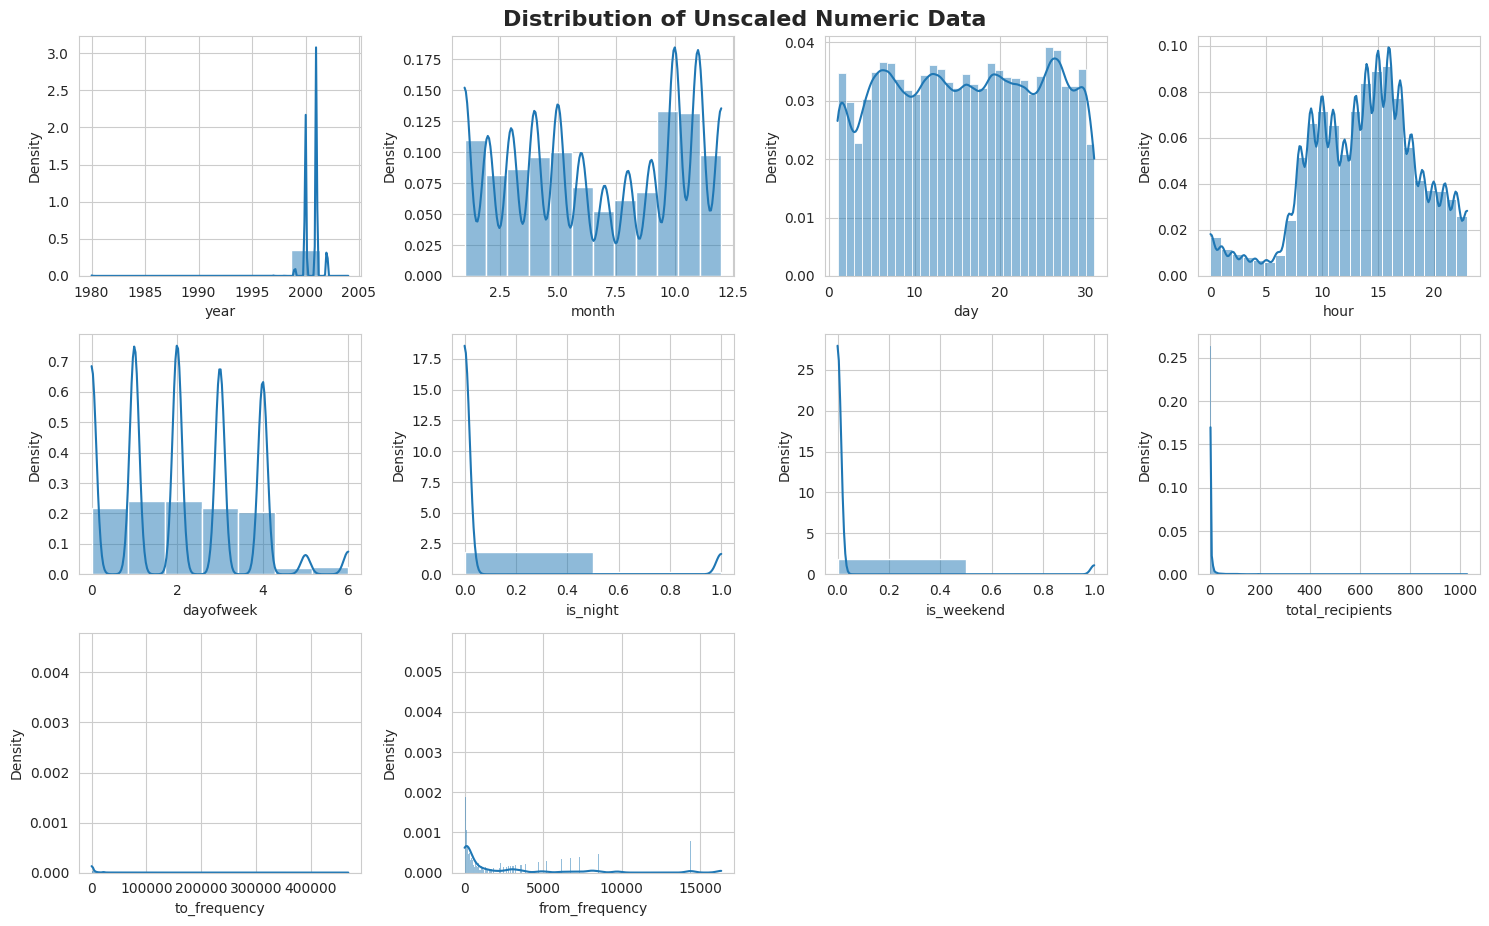

In [30]:

# Set up Seaborn style
sns.set_style("whitegrid")

# Define the number of rows and columns for the grid
num_cols = len(X_structured.columns)
# Define a square-like grid
grid_size = int(np.ceil(np.sqrt(num_cols)))

# Create a figure and subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 12))
axes = axes.flatten()  # Flatten to easily index subplots

# Add a main title for the entire figure
fig.suptitle("Distribution of Unscaled Numeric Data", fontsize=16, fontweight='bold')

# Loop through each column and plot histogram in the respective subplot
for i, col in enumerate(X_structured.columns):
    sns.histplot(X_structured[col], bins=X_structured[col].nunique(), kde=True, stat='density', ax=axes[i])

# Hide empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better display
plt.tight_layout()
plt.show()


 ### Min-Max scaler:
 * keeps the binary data
 * will not distort and skew data
 * emphasizes the outliers and unusual data

In [31]:
# Scaling numerical data of X-structured using Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_structured)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_structured.columns)

# For DBSCAN: everything should be scaled, including binary columns, to ensure distance metrics work correctly.
X_scaled_df.head()


,year,month,day,hour,dayofweek,is_night,is_weekend,total_recipients,to_frequency,from_frequency
0,0.875,0.272727,0.800000,0.086957,0.333333,1.0,0.0,0.0,0.000019,0.000245
1,0.875,0.272727,0.800000,0.086957,0.333333,1.0,0.0,0.0,0.000004,0.000245
2,0.875,0.363636,0.433333,0.913043,0.000000,0.0,0.0,0.0,0.000053,0.000245
3,0.875,0.363636,0.533333,0.043478,0.500000,1.0,0.0,0.0,0.000053,0.000245
4,0.875,0.363636,0.100000,0.782609,0.666667,0.0,0.0,0.0,0.000004,0.000245


In [32]:
X_scaled_df.shape

(517116, 10)

### Visualization after scaling numeric data.

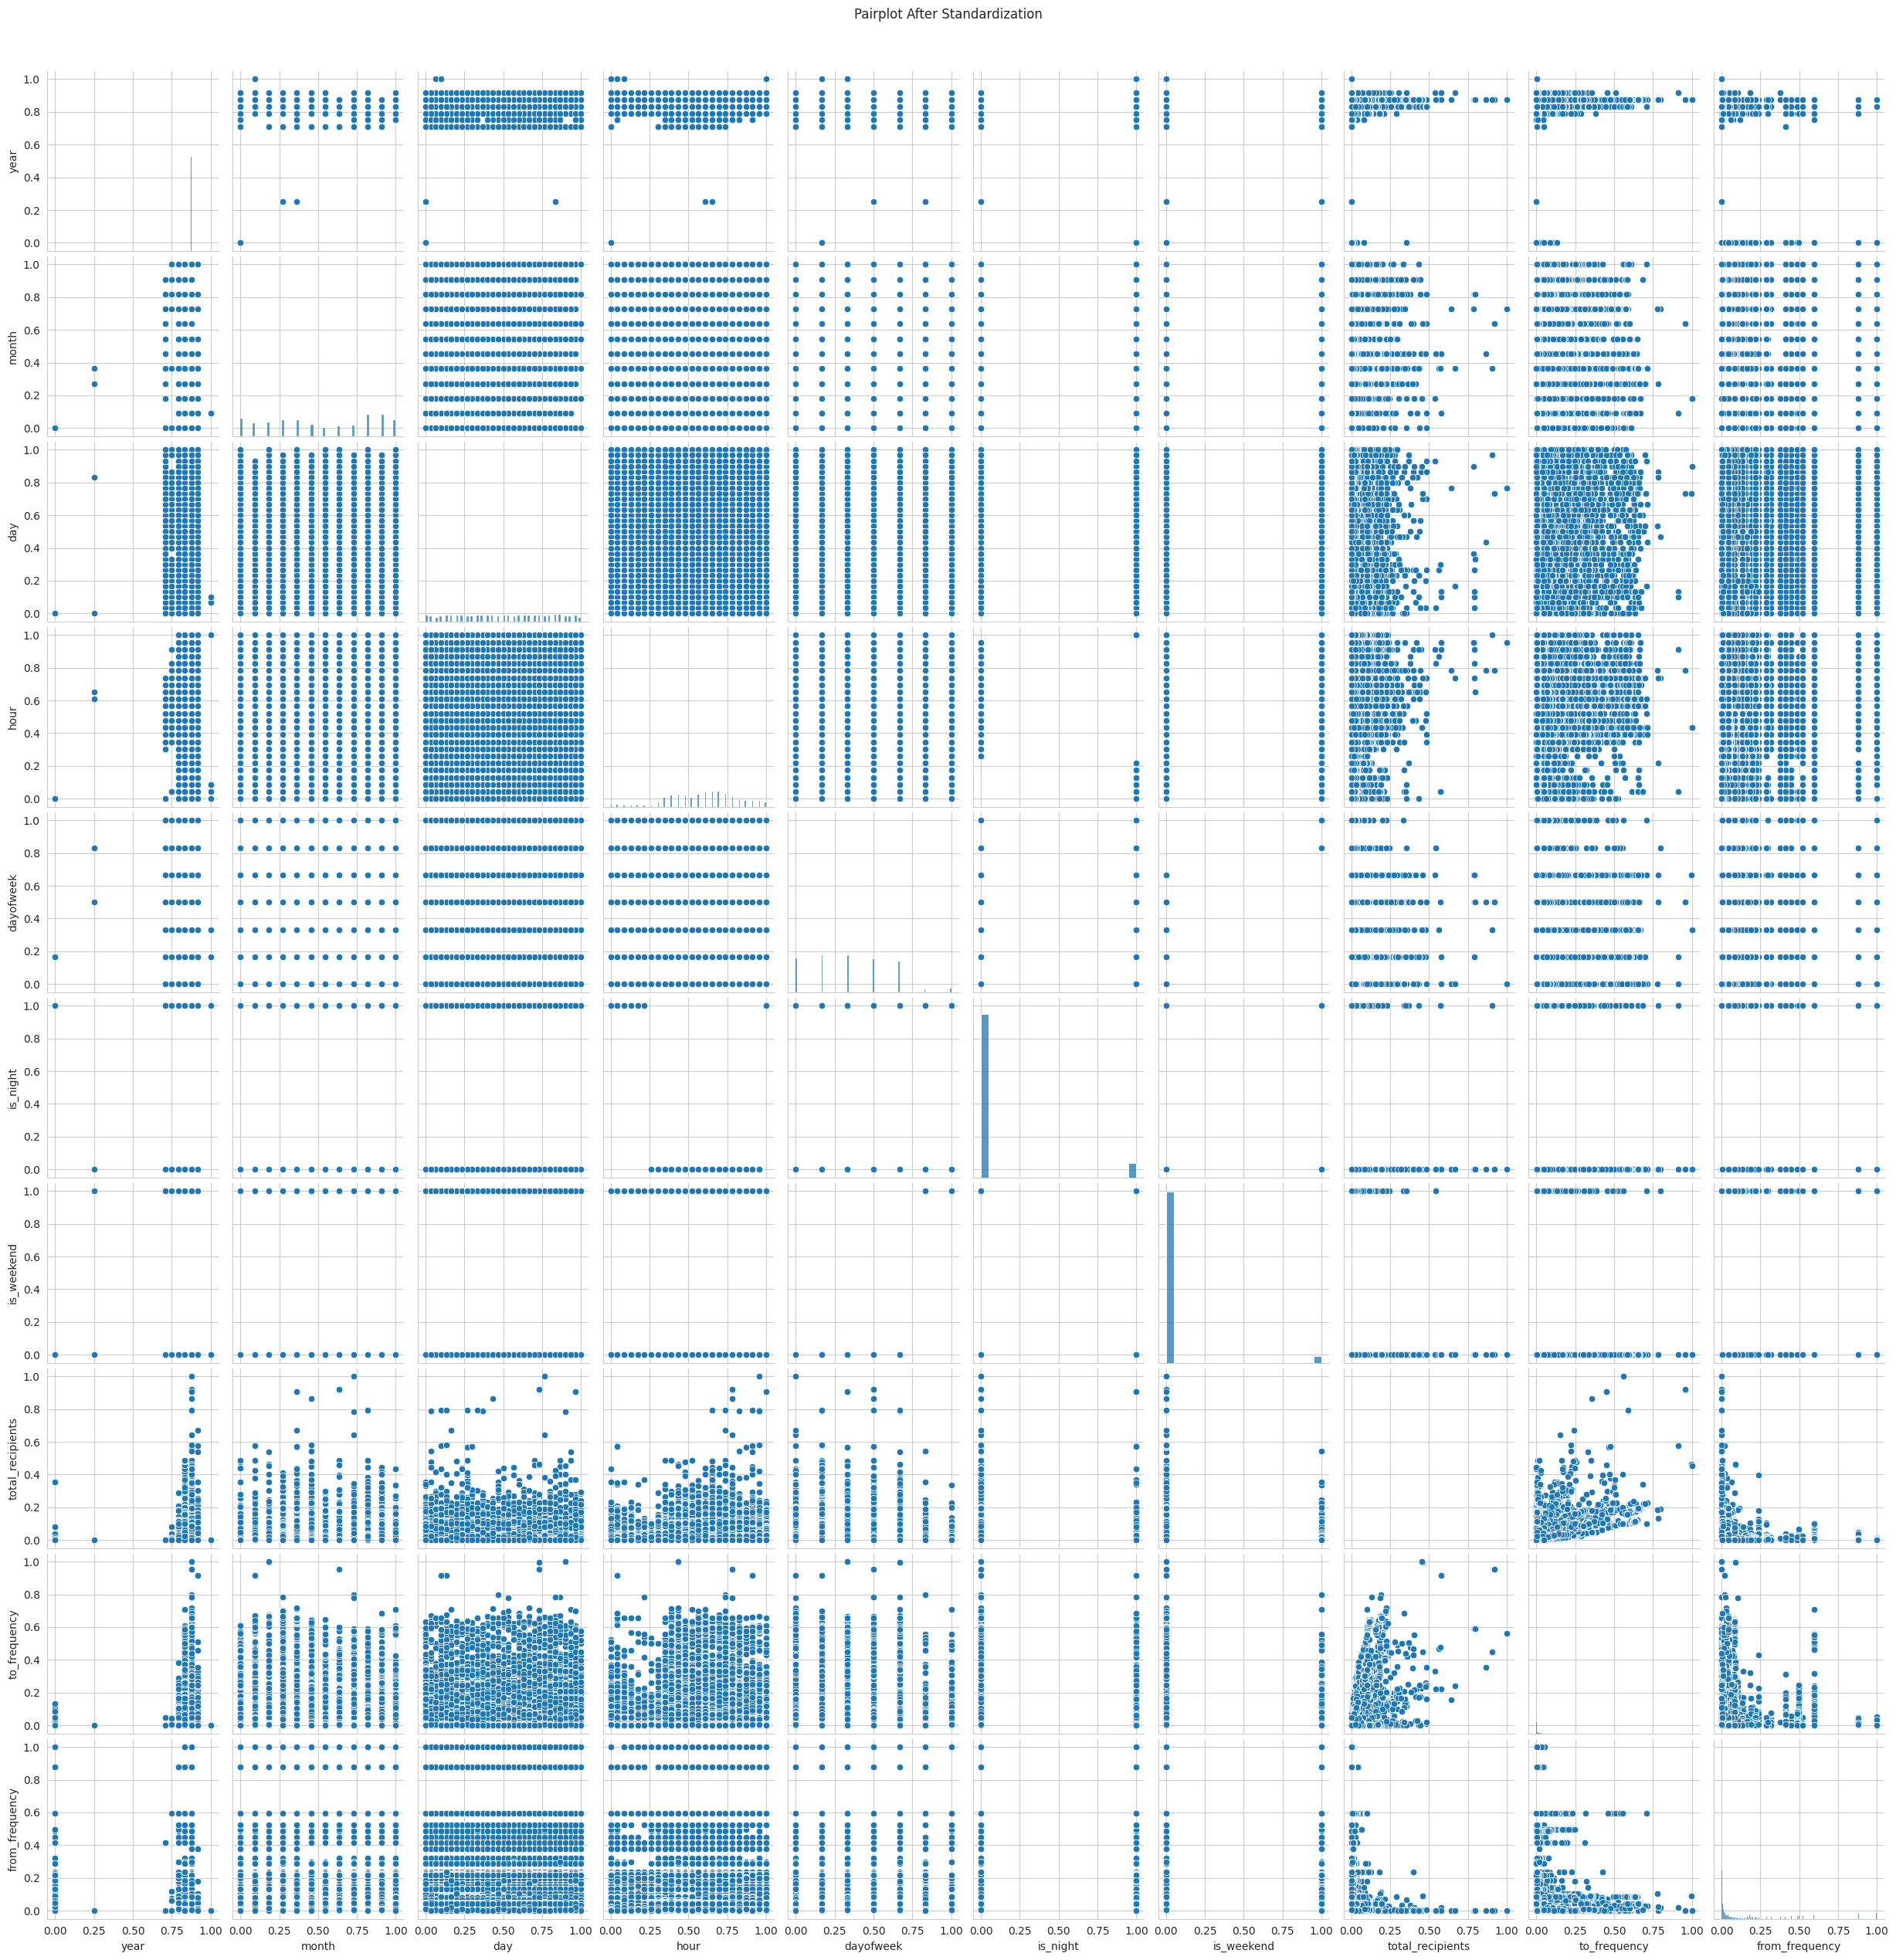

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(X_scaled_df)  # If already standardized
plt.suptitle('Pairplot After Standardization', y=1.02);



---

### 3.2 Pipelines for Text Features (Email Content)

#### 3.2.1 Preprocessing

* Lowercase, remove punctuation, tokenization
* Remove stopwords
* Apply **Porter stemming**

#### 3.2.2 Vectorization

* Use **TF-IDF** to transform cleaned text into vectors

#### 3.2.3 Dimensionality Reduction

* Apply **TruncatedSVD** to reduce dimensionality
* Choose optimal number of components (10–100)

---

In [34]:
# High Frequency Word Remover Class

import pandas as pd
from collections import Counter

class HighFrequencyWordRemover:
    def __init__(self, threshold=300000, chunk_size=10000):
        self.threshold = threshold
        self.chunk_size = chunk_size
        self.high_freq_words = set()

    def fit(self, X, y=None):
        word_counts = Counter()
        for i in range(0, len(X), self.chunk_size):
            chunk = X[i:i+self.chunk_size].str.lower()
            word_counts.update(" ".join(chunk).split())

        self.high_freq_words = {word for word, count in word_counts.items() if count > self.threshold}
        return self

    def transform(self, X):
        return X.apply(lambda text: " ".join([word for word in text.lower().split() if word not in self.high_freq_words]))


In [35]:
# Text Preprocessing Class

nltk.download('stopwords')

class TextPreprocessor(BaseEstimator, TransformerMixin):    # Preprocessor inherits from BaseEstimator and TransformerMixin to ensure scikit-learn compatibility
    def __init__(self):
        self.stopwords = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()

    def clean_text(self, text):
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)      # Remove URLs
        text = re.sub(r'<[^>]*>', '', text)                      # Remove HTML markup
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)              # Remove special characters (keep alphanumerics)
        text = re.sub(r'\s+', ' ', text)                         # Collapse multiple spaces
        text = text.lower().strip()                              # Lowercase and trim
        tokens = text.split()
        tokens = [t for t in tokens if t not in self.stopwords]  # remove stopwords
        tokens = [self.stemmer.stem(t) for t in tokens]          # stem words
        return ' '.join(tokens)

    def fit(self, X, y=None):  # scikit-learn expects transformers to have a fit method
        # No fitting necessary, just return self
        return self

    def transform(self, X):
        # Apply clean_text to each row in the input
        return X.astype(str).apply(self.clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [36]:
# Builing Pipelines for transformation of textual content and subject

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Pipeline for email 'content' with high-frequency word removal
content_pipeline = Pipeline([
    ('remove_high_freq', HighFrequencyWordRemover(threshold=300000)),  # Remove words appearing >500,000 times
    ('preprocess', TextPreprocessor()),
    ('tfidf', TfidfVectorizer(max_features=700)),
    ('svd', TruncatedSVD(n_components=40))
])


# Pipeline for email 'subject'
subject_pipeline = Pipeline([
    ('preprocess', TextPreprocessor()),
    ('tfidf', TfidfVectorizer(max_features=20)),      # Fewer features for short subjects
    ('svd', TruncatedSVD(n_components=4))             # Fewer components for short subjects
])


In [37]:
# Apply pipelines
X_content_vec = content_pipeline.fit_transform(emailsdf['content'])
X_subject_vec = subject_pipeline.fit_transform(emailsdf['Subject'])

In [38]:
# check type and shape
print(type(X_content_vec), ' Shape: ', X_content_vec.shape)
print(type(X_subject_vec), ' Shape: ', X_subject_vec.shape)

<class 'numpy.ndarray'>  Shape:  (517116, 40)
<class 'numpy.ndarray'>  Shape:  (517116, 4)


In [39]:
# Display some of the subject and content vectors
print('content:\n', X_content_vec[5:9, :8])
print('\nsubject:\n', X_subject_vec[5:9, :4])

content:
 [[ 0.1163497  -0.07980245 -0.0268688   0.02080619  0.00388985 -0.03771827
   0.05068388 -0.05120685]
 [ 0.11498064 -0.07698624 -0.02293071  0.01623076  0.00219017 -0.03744828
   0.05038268 -0.05185901]
 [ 0.20256307 -0.16625439  0.00894008  0.05974716 -0.06024246 -0.10542204
   0.10170946 -0.01295918]
 [ 0.24092007 -0.18424156  0.00816842 -0.02492075 -0.08398756 -0.19771191
  -0.05545036 -0.11699662]]

subject:
 [[ 0.00692701  0.01552689  0.0199285   0.03048717]
 [ 0.00703992  0.02353321  0.009902    0.04275884]
 [ 0.60584487 -0.02515465  0.00525134  0.02091169]
 [ 0.99717732 -0.05894143 -0.03040396 -0.02175448]]




---

## 4. **Combining Features**

### 4.1 Merge All Features

* Concatenate structured metadata features and reduced text components


---


In [40]:

# Convert NumPy arrays to DataFrames
X_content_df = pd.DataFrame(X_content_vec, index=X_scaled_df.index)
X_subject_df = pd.DataFrame(X_subject_vec, index=X_scaled_df.index)

# Rename columns for clarity
X_content_df.columns = [f'content_tfidf_{i}' for i in range(X_content_df.shape[1])]
X_subject_df.columns = [f'subject_tfidf_{i}' for i in range(X_subject_df.shape[1])]

# Concatenate all features together
X_combined_df = pd.concat([X_scaled_df, X_content_df, X_subject_df], axis=1)


In [41]:
# Display the shape and first few rows to confirm integration
print(X_combined_df.shape)
X_combined_df.head()

(517116, 54)


,year,month,day,hour,dayofweek,is_night,is_weekend,total_recipients,to_frequency,from_frequency,...,content_tfidf_34,content_tfidf_35,content_tfidf_36,content_tfidf_37,content_tfidf_38,content_tfidf_39,subject_tfidf_0,subject_tfidf_1,subject_tfidf_2,subject_tfidf_3
0,0.875,0.272727,0.800000,0.086957,0.333333,1.0,0.0,0.0,0.000019,0.000245,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.875,0.272727,0.800000,0.086957,0.333333,1.0,0.0,0.0,0.000004,0.000245,...,-0.009833,-0.006696,-0.028968,0.027791,-0.001146,-0.038426,0.000000,0.000000,0.000000,0.000000
2,0.875,0.363636,0.433333,0.913043,0.000000,0.0,0.0,0.0,0.000053,0.000245,...,0.011323,-0.103449,0.002644,0.004515,0.044736,-0.023899,0.000000,0.000000,0.000000,0.000000
3,0.875,0.363636,0.533333,0.043478,0.500000,1.0,0.0,0.0,0.000053,0.000245,...,0.039559,-0.018470,-0.019631,-0.018850,0.027909,0.011561,0.005568,0.003575,0.041878,0.006154
4,0.875,0.363636,0.100000,0.782609,0.666667,0.0,0.0,0.0,0.000004,0.000245,...,0.064164,0.022080,0.034216,-0.022814,0.015407,-0.004437,0.000000,0.000000,0.000000,0.000000




---

## 5. **Clustering**

### 5.1 Algorithm Selection

* Use **DBSCAN** for density-based clustering and anomaly detection

### 5.2 Parameter Tuning

* Use k-distance plot to choose `eps`
* Test multiple values for `min_samples`

### 5.3 Run Clustering

* Fit DBSCAN to the combined feature set
* Label clusters and identify outliers (label = -1)

---


**Elbow Method (for K-Means)**
* Used to find the optimal number of clusters (k).

* Plots inertia (sum of squared distances within clusters) against k.

* The optimal k is where the plot bends (the "elbow"), indicating diminishing returns from adding more clusters.

**K-Distance Plot (for DBSCAN)**
* Used to determine the best eps (radius for density-based clustering).

* Plots distance to the k-th nearest neighbor for all points in ascending order.

* The optimal eps is found at the elbow, where distances sharply increase—this suggests a transition from dense regions to sparse ones.

**.......................  Try K = 10  .......................**

In [42]:
# from sklearn.neighbors import NearestNeighbors
## Select k (usually min_samples)
# k = 10         ## Test min_samples 10

## Fit Nearest Neighbors model to find k-nearest distances
# neigh = NearestNeighbors(n_neighbors=k)
# neigh.fit(X_combined_df)
# distances, indices = neigh.kneighbors(X_combined_df)

## Sort the distances to find the elbow point
# sorted_distances = np.sort(distances[:, k - 1])  ## Select the k-th neighbor's distance

# Plot the k-distance graph
# plt.figure(figsize=(8, 5))
# plt.plot(sorted_distances)
# plt.xlabel("Points sorted by distance")
# plt.ylabel(f"Distance to {k}-th nearest neighbor")
# plt.title("K-Distance Plot for DBSCAN")
# plt.grid(color='gray', linestyle='--', linewidth=0.5)
# plt.show();

**CPU TAKES TOO LONG. USE GPU WITH GPU SPECIALIZED LIBRARIES**

X_combined_df_gpu (517116, 54)
distances (517116, 10)


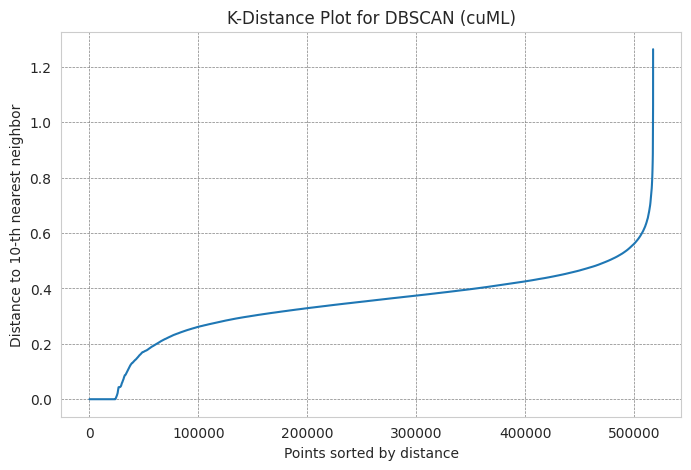

In [43]:
import cudf
import cupy as cp
from cuml.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Convert DataFrame to cuDF for GPU processing
# When using cuML + cuDF + CuPy, the data might be implicitly cast to integers (like int32 or int64)
X_combined_df_gpu = cudf.DataFrame(X_combined_df).astype('float32')
print('X_combined_df_gpu', X_combined_df_gpu.shape)

# Select k (usually min_samples)
k = 10    # Test min_samples 10

# Fit Nearest Neighbors model using cuML
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_combined_df_gpu)

# Compute k-nearest distances
distances, indices = neigh.kneighbors(X_combined_df_gpu)
print('distances', distances.shape)

# Extract the k-th neighbor distances then Convert distances to CuPy array for sorting
distances_k_gpu = cp.array(distances.iloc[:, k - 1])

# Move data back to CPU for plotting
sorted_distances = cp.sort(distances_k_gpu).get()

# Plot the k-distance graph
plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}-th nearest neighbor")
plt.title("K-Distance Plot for DBSCAN (cuML)")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()


In [44]:
X_combined_df_gpu.head()

,year,month,day,hour,dayofweek,is_night,is_weekend,total_recipients,to_frequency,from_frequency,...,content_tfidf_34,content_tfidf_35,content_tfidf_36,content_tfidf_37,content_tfidf_38,content_tfidf_39,subject_tfidf_0,subject_tfidf_1,subject_tfidf_2,subject_tfidf_3
0,0.875,0.272727,0.800000,0.086957,0.333333,1.0,0.0,0.0,0.000019,0.000245,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.875,0.272727,0.800000,0.086957,0.333333,1.0,0.0,0.0,0.000004,0.000245,...,-0.009833,-0.006696,-0.028968,0.027791,-0.001146,-0.038426,0.000000,0.000000,0.000000,0.000000
2,0.875,0.363636,0.433333,0.913043,0.000000,0.0,0.0,0.0,0.000053,0.000245,...,0.011323,-0.103449,0.002644,0.004515,0.044736,-0.023899,0.000000,0.000000,0.000000,0.000000
3,0.875,0.363636,0.533333,0.043478,0.500000,1.0,0.0,0.0,0.000053,0.000245,...,0.039559,-0.018470,-0.019631,-0.018850,0.027909,0.011561,0.005568,0.003575,0.041878,0.006154
4,0.875,0.363636,0.100000,0.782609,0.666667,0.0,0.0,0.0,0.000004,0.000245,...,0.064164,0.022080,0.034216,-0.022814,0.015407,-0.004437,0.000000,0.000000,0.000000,0.000000


**.......................  Best eps = 1,  for K = 10  .......................**

In [45]:

# from sklearn.cluster import DBSCAN

# # Define DBSCAN parameters
# dbscan_k10 = DBSCAN(eps=0.4, min_samples=10, metric='manhattan', n_jobs=1)

# # Fit DBSCAN on the combined features
# clusters_k10 = dbscan_k10.fit_predict(X_combined_df)


In [46]:
import cudf
from cuml.cluster import DBSCAN  # Import cuML's DBSCAN for GPU acceleration

# Define DBSCAN parameters (same as sklearn)
dbscan_k10 = DBSCAN(eps=1, min_samples=10)

# Fit DBSCAN on the combined features (data must be in a cuDF DataFrame or NumPy array)
clusters_k10 = dbscan_k10.fit_predict(X_combined_df_gpu)


[2025-06-06 07:30:44.702] [CUML] [warning] Batch size limited by the chosen integer type (4 bytes). 4852 -> 4152. Using the larger integer type might result in better performance


In [47]:
print(type(clusters_k10), clusters_k10.shape)

<class 'cudf.core.series.Series'> (517116,)


In [48]:
# Add cluster labels to the DataFrame
X_combined_df_gpu['cluster_k10'] = clusters_k10

# Check results
print(X_combined_df_gpu['cluster_k10'].value_counts())

cluster_k10
 1    459848
 0     37690
 2     14955
 3      4593
-1        30
Name: count, dtype: int64


**.......................  Try K = 30  .......................**

In [49]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors

# # Select k (usually min_samples)
# k = 30         # Start with 30 min_samples

# # Fit Nearest Neighbors model to find k-nearest distances
# neigh = NearestNeighbors(n_neighbors=k)
# neigh.fit(X_combined_df)
# distances, indices = neigh.kneighbors(X_combined_df)

# # Sort the distances to find the elbow point
# sorted_distances = np.sort(distances[:, k - 1])  # Select the k-th neighbor's distance

# # Plot the k-distance graph
# plt.figure(figsize=(8, 5))
# plt.plot(sorted_distances)
# plt.xlabel("Points sorted by distance")
# plt.ylabel(f"Distance to {k}-th nearest neighbor")
# plt.title("K-Distance Plot for DBSCAN")
# plt.grid(color='gray', linestyle='--', linewidth=0.5)
# plt.show();

distances <class 'cudf.core.dataframe.DataFrame'> (517116, 30)


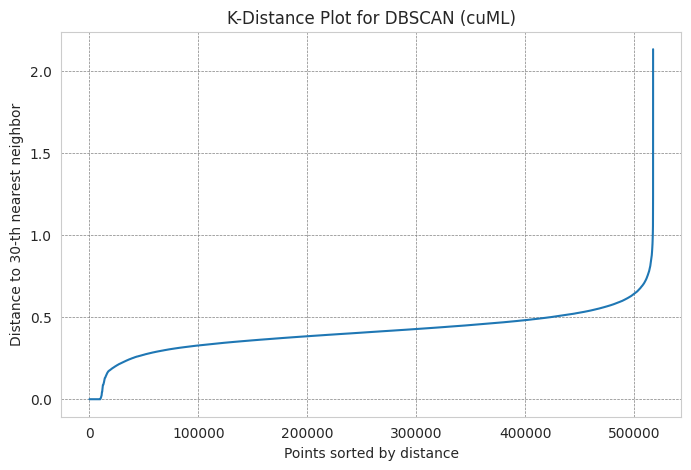

In [50]:

# Select k (usually min_samples)
k = 30                                                       # Test min_samples 30

# Fit Nearest Neighbors model using cuML
neigh = NearestNeighbors(n_neighbors=k, metric="euclidean")  # You can change metric
neigh.fit(X_combined_df_gpu)

# Compute k-nearest distances
distances, indices = neigh.kneighbors(X_combined_df_gpu)
print("distances", type(distances), distances.shape)

# Convert distances to CuPy array for sorting
distances_gpu = cp.array(distances.iloc[:, k - 1])          # Move data back to CPU for plotting
sorted_distances = cp.sort(distances_gpu).get()

# Plot the k-distance graph
plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}-th nearest neighbor")
plt.title("K-Distance Plot for DBSCAN (cuML)")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()


**.......................  Best eps = 0.6  for K = 30  .......................**

In [51]:
import cudf
from cuml.cluster import DBSCAN  # Import cuML's DBSCAN for GPU acceleration

# Define DBSCAN parameters (same as sklearn)
dbscan_k30 = DBSCAN(eps=0.6, min_samples=30)

# Fit DBSCAN on the combined features (data must be in a cuDF DataFrame or NumPy array)
clusters_k30 = dbscan_k30.fit_predict(X_combined_df_gpu)


[2025-06-06 07:33:02.026] [CUML] [warning] Batch size limited by the chosen integer type (4 bytes). 4808 -> 4152. Using the larger integer type might result in better performance


In [52]:
# Add cluster labels to the DataFrame
X_combined_df_gpu['cluster_k30'] = clusters_k30

# Check results
print(X_combined_df_gpu['cluster_k30'].value_counts())

cluster_k30
 1     453236
 0      22349
 4      13326
 2      10253
-1       9581
 12      3037
 3       1231
 11       656
 17       542
 18       479
 9        263
 30       173
 25       150
 16       131
 23       118
 10       116
 6        112
 13       107
 26       100
 21        93
 24        87
 15        82
 20        72
 38        64
 8         60
 31        51
 35        50
 19        48
 37        43
 14        42
 34        41
 41        40
 28        39
 29        37
 5         37
 42        32
 7         32
 22        31
 27        31
 40        31
 32        30
 39        26
 33        26
 36        22
 43         9
Name: count, dtype: int64




---

## 6. **Evaluation & Visualization**

### 6.1 Cluster Analysis

* Count of samples in each cluster
* Inspect sample emails from each cluster

### 6.2 Outlier Analysis

* Investigate emails labeled as noise
* Look for patterns: odd sender/recipient combos, abnormal subjects/content

---


In DBSCAN, cluster -1 represents noise points or outliers, the data points that do not belong to any dense region, meaning they are considered anomalies.

In [53]:

# Add cluster labels from DBSCAN to filtered emails DataFrame
emailsdf['cluster_k10'] = X_combined_df_gpu['cluster_k10'].to_pandas()

# Extract emails classified as anomalies (-1)
anomalous_emails = emailsdf[emailsdf['cluster_k10'] == -1]


In [54]:
# Change notebook settings to display full content
pd.set_option('display.max_colwidth', None)

# Display a sample of outlier emails
anomalous_emails[['From', 'To', 'Subject', 'content']].sample(2)


,From,To,Subject,content
297017,Scott Bolto,"sue.nord@enron.com, stephen.burns@enron.com, allison.navin@enron.co","EBS/BBI news release, message points & Q&A","I am forwarding the talking points and briefing info on the Blockbuster/EBS \nsituation from the EBS PR Dept. Sue/Steve/Allison - they have asked for \nguidance and a dowload on the cable issue in anticipation on the NAB \nconference in mid-April. Let's discuss on the next call. Thanks.\n\nScott\n----- Forwarded by Scott Bolton/Enron Communications on 03/12/01 12:19 PM \n-----\n\n\tDonna Kocourek\n\t03/12/01 11:16 AM\n\t\t \n\t\t To: Scott Bolton/Enron Communications@Enron Communications\n\t\t cc: \n\t\t Subject: EBS/BBI news release, message points & Q&As\n\n___________________________\nDonna M.R. Kocourek\nEnron Broadband Services, Inc.\nManager, Event Marketing\n\nPH: 503/886-0181\nCELL: 503/701-6866\nFAX: 503/425-6008\ndonna_kocourek@enron.net\nwww.enron.net\n\n----- Forwarded by Donna Kocourek/Enron Communications on 03/12/01 11:20 AM \n-----\n\n\tKelly Kimberly\n\tSent by: Stacy Walker\n\t03/12/01 09:21 AM\n\t\t \n\t\t To: Darran Binns/Enron Communications@Enron Communications, Terrie \nJames/Enron Communications@Enron Communications, Shelly Mansfield/Enron \nCommunications@Enron Communications, Maryanne Miller/Enron \nCommunications@Enron Communications, Eddie Sera/Enron Communications@Enron \nCommunications, Carin Andre/Enron Communications@Enron Communications, \nColleen Case/Enron Communications@Enron Communications, Anita Cullen/Enron \nCommunications@Enron Communications, Paul Gyles/Enron Communications@Enron \nCommunications, Janet Johnson/Enron Communications@Enron Communications, \nDonna Kocourek/Enron Communications@Enron Communications, Jessica Nevin/Enron \nCommunications@Enron Communications, Tom Ogden/Enron Communications@Enron \nCommunications, Laurie Purviance/Enron Communications@Enron Communications, \nTracy Smith/Enron Communications@Enron Communications, Genevieve Athens/Enron \nCommunications@Enron Communications, Steve McNear/Enron Communications@Enron \nCommunications, Courtney Childers/Enron Communications@Enron Communications, \nEllie Ahmadi/Enron Communications@Enron Communications, Mary Anne \nCollins/Enron Communications@Enron Communications, Syni Brent/Enron \nCommunications@Enron Communications, Leah Ragiel/Enron Communications@Enron \nCommunications, Randall Hicks/Enron Communications@Enron Communications, Mark \nSolana/Enron Communications@Enron Communications, Elizabeth Peters/Enron \nCommunications@Enron Communications, Anthony Mends/Enron Communications@Enron \nCommunications, Candi Woods/Enron Communications@Enron Communications, Rita \nHartfield/Enron Communications@Enron Communications, David Gossett/Enron \nCommunications@Enron Communications, Holly Bradford-Nelson/Enron \nCommunications@Enron Communications, Martin Lassen/Enron Communications@Enron \nCommunications, Norman Levine/Enron Communications@Enron Communications, \nBessik Matchavariani/Enron Communications@Enron Communications, Lynette \nMalone/Enron Communications@Enron Communications, Robin Hilp/Enron \nCommunications@Enron Communications, Cheryle Wiese/Enron Communications@Enron \nCommunications, Krista Reed/Enron Communications@Enron Communications, Debora \nWallace/Enron Communications@Enron Communications\n\t\t cc: \n\t\t Subject: EBS/BBI news release, message points & Q&As\n\nAttached are the EBS news release, message points and Q&As regarding our \ntermination of our contract with Blockbuster. You may distribute the news \nrelease, but use the message points and Q and As only for communicating with \nyour audiences--do not distribute them. Please refer all media inquiries to \nme. Let me know if you have questions.\n\n\n\n\n"
290401,Sarah Novose,"bruno.gaillard@enron.com, susan.mara@enron.com, jeff.dasovich@enron.com, \n\tjames.steffes@enron.com, mary.hain@enron.com, \n\trichard.shapiro@enron.com, joe.hartsoe@enron.co",FERC Order Initiating Investigatio,"In 

In [55]:
# Group emails by cluster
grouped_clusters = emailsdf.groupby('cluster_k10')

# Iterate over each cluster and display sample emails
for cluster_label, cluster_df in grouped_clusters:
    print(f"\n*******************\n******************  Cluster {int(cluster_label)} Sample Emails:")
    display(cluster_df[['From', 'To', 'Subject', 'content']].sample(3))



*******************
******************  Cluster -1 Sample Emails:


,From,To,Subject,content
103987,Kay Man,carlos.sole@enron.co,Re: Withdrawa,"I cannot imagine a shirt larger than the one you received. Yikes. Sounds \nlike Neil still has a chance for a new shirt.\n\nWe'll have to allow extra time next Monday for a double de-brief.\n\nKay\n\n\nFrom: Carlos Sole on 03/19/2001 09:46 AM\nTo: kay.mann@enron.com\ncc: \n\nSubject: Withdrawal\n\nMust confess that it's a bit wierd with you not being here. Although we've \ntalked on the phone, I''ve ginda gotten used to having a face-to-face weekend \ndebrief each morning to let my coffee kick in.\n\nPS Scott also got thw rong shirt size from A&K, he wears XXL and is \ndisappointed he only got a XL. I sure hope that they got JD's size right. \nI'll have to check with Lance and see what he got.\n\nCarlos Sole'\nSenior Counsel\nEnron North America Corp.\n1400 Smith Street\nHouston, Texas 77002-7361\n\n(713) 345-8191 (phone)\n713 646-3393 (fax)\n\n"
297017,Scott Bolto,"sue.nord@enron.com, stephen.burns@enron.com, allison.navin@enron.co","EBS/BBI news release, message points & Q&A","I am forwarding the talking points and briefing info on the Blockbuster/EBS \nsituation from the EBS PR Dept. Sue/Steve/Allison - they have asked for \nguidance and a dowload on the cable issue in anticipation on the NAB \nconference in mid-April. Let's discuss on the next call. Thanks.\n\nScott\n----- Forwarded by Scott Bolton/Enron Communications on 03/12/01 12:19 PM \n-----\n\n\tDonna Kocourek\n\t03/12/01 11:16 AM\n\t\t \n\t\t To: Scott Bolton/Enron Communications@Enron Communications\n\t\t cc: \n\t\t Subject: EBS/BBI news release, message points & Q&As\n\n___________________________\nDonna M.R. Kocourek\nEnron Broadband Services, Inc.\nManager, Event Marketing\n\nPH: 503/886-0181\nCELL: 503/701-6866\nFAX: 503/425-6008\ndonna_kocourek@enron.net\nwww.enron.net\n\n----- Forwarded by Donna Kocourek/Enron Communications on 03/12/01 11:20 AM \n-----\n\n\tKelly Kimberly\n\tSent by: Stacy Walker\n\t03/12/01 09:21 AM\n\t\t \n\t\t To: Darran Binns/Enron Communications@Enron Communications, Terrie \nJames/Enron Communications@Enron Communications, Shelly Mansfield/Enron \nCommunications@Enron Communications, Maryanne Miller/Enron \nCommunications@Enron Communications, Eddie Sera/Enron Communications@Enron \nCommunications, Carin Andre/Enron Communications@Enron Communications, \nColleen Case/Enron Communications@Enron Communications, Anita Cullen/Enron \nCommunications@Enron Communications, Paul Gyles/Enron Communications@Enron \nCommunications, Janet Johnson/Enron Communications@Enron Communications, \nDonna Kocourek/Enron Communications@Enron Communications, Jessica Nevin/Enron \nCommunications@Enron Communications, Tom Ogden/Enron Communications@Enron \nCommunications, Laurie Purviance/Enron Communications@Enron Communications, \nTracy Smith/Enron Communications@Enron Communications, Genevieve Athens/Enron \nCommunications@Enron Communications, Steve McNear/Enron Communications@Enron \nCommunications, Courtney Childers/Enron Communications@Enron Communications, \nEllie Ahmadi/Enron Communications@Enron Communications, Mary Anne \nCollins/Enron Communications@Enron Communications, Syni Brent/Enron \nCommunications@Enron Communications, Leah Ragiel/Enron Communications@Enron \nCommunications, Randall Hicks/Enron Communications@Enron Communications, Mark \nSolana/Enron Communications@Enron Communications, Elizabeth Peters/Enron \nCommunications@Enron Communications, Anthony Mends/Enron Communications@Enron \nCommunications, Candi Woods/Enron Communications@Enron Communications, Rita \nHartfield/Enron Communications@Enron Communications, David Gossett/Enron \nCommunications@Enron Communications, Holly Bradford-Nelson/Enron \nCommunications@Enron Communications, Martin Lassen/Enron Communications@Enron \nCommunications, Norman Levine/Enron Communications@Enron Communications, \nBessik Matchavariani/Enron Communications@Enron Communications, Lynette \nMalone/Enron Communications@Enron Co


*******************
******************  Cluster 0 Sample Emails:


,From,To,Subject,content
31927,Jay Rickerts,enl-members-html@estutenws11.energy.williams.co,Williams Energy News Live -- today's video newscas,"\n =09 =09 Dear Eric, There are several hearings and at least one markup =\nscheduled on Wednesday from Capitol Hill. Washington Bureau Chief Peter Co=\nok reports members of Congress will be considering the expansion of alterna=\ntive energy production on federal lands and looking at ways to improve safe=\nty at nuclear plants. Also on Wednesday, CTN, INGAA and the AGA are spon=\nsoring a major energy conference. Panelists at the conference include FERC=\n Commissioner Nora Mead Brownell, energy attorney and former FERC Commissio=\nner Don Santa and Curt Launer of Credit Suisse First Boston among others. =\nThe Washington bureau will have updates from the conferences Wednesday morn=\ning. Also from the Washington bureau, National Academy of Sciences Senior=\n Program Officer Alan Crane will stop by to give us a preview of the hearin=\ng on Friday revisiting CAFE standards. He'll join us during the 1:00 p.m. =\nET newscast on Wednesday. The Houston bureau will have an update on Rep=\n. Joe Barton (R) Texas, and a portion of his electricity bill concerning Re=\ngional Transmission Organizations that's expected to be released soon. Rep.=\n Barton also talks about ERCOT, operators of 85% of the Texas power grid, a=\nnd how the organization is a model for these RTOs. Jacobs Consultancy In=\ncorporated Managing Director Karl Bartholomew will join us from the Housto=\nn bureau on Wednesday. He'll discuss how the industry will be affected by l=\nowering the sulfur content in diesel fuel during the noon ET newscast tomor=\nrow. On Wednesday from the West Coast bureau, California Governor Gray D=\navis' Press Secretary Steve Maviglio talks about what compromises are being=\n made to push a Southern California Edison bailout plan through the State L=\negislature. ENL's Kym McNicholas says we'll also have more on the Califor=\nnia PUC's decision on the CDWR Rate Agreement and reaction from the Governo=\nr's office. And California ISO Spokesperson Gregg Fishman responds to conc=\nerns that the grid operator has violated the FERC's orders on creditworthin=\ness. Log on Wednesday for these reports from the West Coast bureau. Dail=\ny Update Note: You can now send today's Daily Update to a friend. If you t=\nhink someone you know would be interested in the update, simply click the i=\ncon that says View today's Energy Wrap video, type in your friend's e-mail =\naddress and send them Today's Video or Tomorrow's Daily Wrap Up. We now h=\nave wireless and text-only capabilities and you can receive the Daily Updat=\ne at a secondary e-mail address if you choose. To select a text form or to=\n add a secondary e-mail address, login to ""Change Settings"" and edit your ""=\nAccount Information."" We hope you'll take advantage, and enjoy this new se=\nrvice. Keep in mind things are subject to change at a moment's notice. Oc=\ncasionally guests cancel or change time slots. We'll continue to do our be=\nst to keep you updated on future interviews and events. Be sure to watc=\nh our newscasts every business day - 9 a.m. to 5 p.m. ET, at the top of eac=\nh hour. =09 =09=09=09=09\n =09=09=09=09=09=09 =09\n=09 =09Jay Rickerts, EnergyNewsLive.com Anchor View today's Energy Wrap vi=\ndeo (Requires Windows Media Player or Real Player ) Experience all that=\n Williams Energy News Live has to offer! If you are receiving this letter=\n for the first time and wish to continue, subscribe now To stop receivin=\ng this letter, unsubscribe now If you are having trouble receiving this =\ne-mail, please let us know or call (800) WILLIAMS (800-945-5426) weekdays=\n, 7am-7pm CST. Comments? Suggestions? Let us know or call (800) WILLI=\nAMS (800-945-5426) weekdays, 7am-7pm CST. Copyright 2001 Williams Energy=\n News Live, LLC. All Rights Reserved. =09=09=09=09=09\n"
374185,"Love, Dianne",plove@enron.co,FW: Ask Phillip about Bob S


*******************
******************  Cluster 1 Sample Emails:


,From,To,Subject,content
494281,Carol St Clai,stephanie.panus@enron.co,Re: Exelon Generation / Enron - form of Guaranty from Enron Corp,"Yes.\n\nCarol St. Clair\nEB 3889\n713-853-3989 (Phone)\n713-646-3393 (Fax)\ncarol.st.clair@enron.com\n\n\n\n\tStephanie Panus@ENRON\n\t06/04/01 08:51 AM\n\t\t \n\t\t To: Carol St Clair/HOU/ECT@ECT\n\t\t cc: \n\t\t Subject: Exelon Generation / Enron - form of Guaranty from Enron Corp.\n\n\nCarol,\nPlease see below from Exelon Generation. They are looking for our form of \nGuaranty. Is it ok to send?\n----- Forwarded by Stephanie Panus/NA/Enron on 06/04/2001 08:51 AM -----\n\n\ttglisson@mwe.com\n\t06/01/2001 12:37 PM\n\t\t \n\t\t To: stephanie.panus@enron.com\n\t\t cc: \n\t\t Subject: Exelon Generation / Enron - form of Guaranty from Enron Corp.\n\n\n\nStephanie,\nWould you forward to me a copy of Enron Corp.'s form of Guaranty?\nThank you,\n\nTim Glisson\nLegal Assistant\nMcDermott, Will & Emery\n227 West Monroe Street\nChicago, IL 60606-5096\n312 984-3274 Telephone\n312 984-7700 Telefax\ntglisson@mwe.com\n\n******************************************************************************\n*******\n\nThis message is a PRIVATE communication. If you are not the intended\nrecipient, please do not read, copy, or use it, and do not disclose it to\nothers. Please notify the sender of the delivery error by replying to this\nmessage, and then delete it from your system. Thank you.\n******************************************************************************\n*******\n\n\nFor more information on McDERMOTT, WILL & EMERY please visit our website at:\nhttp://www.mwe.com/\n\n\n\n\n"
254899,Maureen McVicke,andou_wdc@nikkei.co,Re: Phot,Here's the picture of Steve Kean. \n\n
301673,Jeffrey A Shankma,michele.marvin@enron.co,Re: Opportunities in Japa,"Very strong need for people in Japan next august. I'd like to get some \npeople interested in helping start there, or get there after some enron \nindoctrination. Thanks. Jeff\n\n\nFrom: Michele Nezi Marvin@ENRON COMMUNICATIONS on 10/02/2000 01:56 PM\nTo: Suzanne Farrow/HOU/EES@EES@ENRON, Jeffrey A Shankman/HOU/ECT@ECT\ncc: Kristin Gandy/NA/Enron@Enron \nSubject: Re: Opportunities in Japan \n\nI asked Tess about Japan while we were up at Wharton and she wanted to try to \nremain under the radar screen as far as her Japanese expertise because she \nwas trying to get some personal issues resolved. She also wanted to stick it \nout in the Steel Group until some of the uncertaintly was resolved.\n\nI agree that we should put Chris on the resume list. I am very hesitant to \nguarantee or even indicate where people would go once they get to Enron \nduring the interview process. I know that last year we were looking for \npeople who were interested in Asian opportunities (especially Korea and \nChina), yet by the time these folks started we no longer had opportunities \navailable there, leading to a lot of disappointment and disenchantment with \nEnron. Jeff, how likely is it that we will still have a strong need for \npeople in Japan next August? \n\nMichele Nezi Marvin\nManager\nEnron Broadband Services\n(713)853-6848\n\n\n\n\tSuzanne Farrow@EES\n\t10/02/00 01:52 PM\n\t\t\n\t\t To: Jeffrey A Shankman/HOU/ECT@ECT\n\t\t cc: Kristin Gandy/NA/Enron@Enron, Michele Nezi Marvin/Enron \nCommunications@Enron Communications\n\t\t Subject: Re: Opportunities in Japan\n\nI think he has a strong resume. He's definitely worth putting on the \ninterview list.\n\nAs for Japan opportunities, is there a way to get Tess Dyar plugged into \nthose? She just started (from Wharton) after spending nearly 10 years at \nGoldman in Japan. She definitely has an interest in continuing her work with \nthe country. I think she's been a little disappointed since getting here and \nseeing APACHI dissolved.\n\nSuzanne\n\n\n\n\nTo: Kristin Gandy/NA/Enron@Enron\ncc: Michele Nezi Marvin/Enron Communications@Enron Communications, Suzanne \nFarrow/HOU/EES@EES \nSubject: Opportunities in Japan\n\nwhat do you g


*******************
******************  Cluster 2 Sample Emails:


,From,To,Subject,content
180767,Kimberly Hilli,peoplefinder@enron.co,Re: PeopleFinder change confirmation #961407177.37,"PeopleFinder <peoplefinder@enron.com> on 06/19/2000 06:01:23 AM\nPlease respond to peoplefinder@enron.com\nTo: John.J.Lavorato@enron.com\ncc: \n\nSubject: PeopleFinder change confirmation #961407177.370\n\n\nThis is a change ticket from the PeopleFinder.\n\nThe PeopleFinder received these changes to your information\nfrom the LAN Phonebook on 6/19/2000:\n\n change Extension to ""7991""\n change Office to ""713-853-7991""\n\nIf you want these changes made to your information,\nsimply reply to this message:\nIn Netscape Mail, press the ""Re: Mail"" button and then ""Send"".\nIn Lotus Notes, press the ""Reply"" button and then ""Send"".\nOnly the subject line with the confirmation ID is important.\n\nIf you don't want these changes, throw this message away.\n\nThere is currently no way to approve some of these changes and not others.\nIf you don't want all of these changes, please discard this message\nand you can submit your own changes through the peoplefinder at\nhttp://home.enron.com/pfinder.\nIf you prefer not to receive these confirmations in the future,\nplease visit the Change My Info page and turn off Confirm External Changes.\n\n"
330392,"Crenshaw, Shirley","program.associate@enron.com, doug.gilbert-smith@enron.com, \n\tharry.arora@enron.com, robert.stalford@enron.com, \n\tdana.davis@enron.com, steve.wang@enron.com, iris.mack@enron.com, \n\tjim.meyn@enron.com, nick.hiemstra@enron.com, \n\trahul.seksaria@enron.com, pete.heintzelman@enron.com, \n\td..baughman@enron.com, tom.may@enron.com, anne.dean@enron.com, \n\tclint.dean@enron.com, utku.gulmeden@enron.com, \n\tutku.gulmeden@enron.com, john.will@enron.com, lloyd.will@enron.com, \n\tc..aucoin@enron.com, edith.cross@enron.com, naveen.andrews@enron.com, \n\trika.imai@enron.com, ed.mcmichael@enron.com, mark.breese@enron.com, \n\td..cisneros@enron.com, sanjeev.khanna@enron.com, \n\tmichelle.zhang@enron.com, zhiyun.yang@enron.com, \n\te-mail <.adam@enron.com>, e-mail <.alex@enron.com>, \n\te-mail <.amitava@enron.com>, e-mail <.anguel@enron.com>, \n\te-mail <.anita@enron.com>, e-mail <.bob@enron.com>, \n\te-mail <.chonawee@enron.com>, e-mail <.christopher@enron.com>, \n\te-mail <.gwyn@enron.com>, e-mail <.heather@enron.com>, \n\te-mail <.jaesoo@enron.com>, e-mail <.jason@enron.com>, \n\te-mail <.jose@enron.com>, e-mail <.joseph@enron.com>, \n\te-mail <.karthik@enron.com>, e-mail <.kenneth@enron.com>, \n\te-mail <.kevin@enron.com>, e-mail <.lance@enron.com>, \n\te-mail <.leann@enron.com>, e-mail <.martin@enron.com>, \n\te-mail <.maureen@enron.com>, e-mail <.mauricio@enron.com>, \n\te-mail <.mike@enron.com>, e-mail <.mitra@enron.com>, \n\te-mail <.nelson@enron.com>, e-mail <.osman@enron.com>, \n\te-mail <.paulo@enron.com>, e-mail <.pinnamaneni@enron.com>, \n\te-mail <.pravas@enron.com>, e-mail <.praveen@enron.com>, \n\te-mail <.rabi@enron.com>, e-mail <.rakesh@enron.com>, \n\te-mail <.sandeep@enron.com>, e-mail <.sarah@enron.com>, \n\te-mail <.seksan@enron.com>, e-mail <.sevil@enron.com>, \n\te-mail <.shalesh@enron.com>, e-mail <.shane@enron.com>, \n\te-mail <.shravan@enron.com>, e-mail <.sofya@enron.com>, \n\te-mail <.sriram@enron.com>, e-mail <.steve@enron.com>, \n\te-mail <.tanya@enron.com>, e-mail <.therese@enron.com>, \n\te-mail <.tom@enron.com>, e-mail <.tom@enron.com>, \n\te-mail <.vasant@enron.com>, e-mail <.vince@enron.com>, \n\te-mail <.wichai@enron.com>, e-mail <.william@enron.com>, \n\te-mail <.zimin@enron.com",Presentation Announcemen,"\nYou are invited to attend the following presentation: \n\nPSIM: A Power Simulation Tool\n\nPSIM is a proprietary model developed by Enron Research Group.\n\n?\tIt takes Power, Gas, Weather and demand information into consideration and \n\tuses Monte-Carlo simulation to assess the expected deal value and risk distribution. \n?\tIt evaluates complex electricity related contracts such\nas Full Requirement and load fo


*******************
******************  Cluster 3 Sample Emails:


,From,To,Subject,content
369349,Rob G Ga,"bboeh@opic.gov, frank.kluesener@kfw.de, garven@stoneweb.com, \n\tbradley.barta@stoneweb.co",Siemens negotiation,"Two agreements have been negotiated with Siemens as part of the plant \nturnover for Provisional Completion Phase III on oil: 1) the EOT Claim \nAgreement between Siemens and SCC and 2) modifications to the TAA between \nSiemens and EPE.\n\nThe changes which the lenders should review are as follows:\n\nEOT Claim Agreement\n\n14 Day Availability Test with respect to Provisional Completion Phase III on \noil, on a look-back basis over 6 months, required as a specific performance \nrequirement\nAfter PC on oil, Siemens can demobilize\nCompensation for commissioning on oil $5,720,000; $30,000 per day for owner \ndelay\nBonus of $15,000 per day that PC achieved before 17 Feb\nPhase III Substantial Completion on gas\n60 days prior written notice on gas availability\nIf sound level guarantees demonstrated on oil, only need to demonstrate far \nfield sound on gas\nOwner must operate and maintain per O&M manuals and industry practices on \noil; if not, owner must correct items materially affecting Contractor's \ncommissioning obligations\nPerformance guarantees remain in tact per EPC\nLong stop date on Phase III Substantial Completion on gas of 31 Dec 01\nSubstantial Completion on gas - punchlist limited to deficiencies from Work \nperformed to achieve Substantial Completion on gas\nRisk of Loss remains with owner during commisioning on gas\nSiemens agrees to enter into negotiations to provide operational assistance\nDegradation - agree to use curves with credit to owner for degradation during \ncommissioning\nCompensation for commissioning on natural gas $1,220,000 lump sum; $20,000 \nper day for owner delay\nWarranty - 6 months after Provisional Completion on oil\nOption to buy extended warranty for up to 6 months at $175,000; must elect 60 \ndays prior to expiration of Primary Warranty Period\nPerformance LD's on gas per the EPC contract with first $4,000,000 forgiven \nby owner\nDelay LD's on gas do not start until 60 days after performance test on gas\nPayments to be paid (including EOTof $5,720,000): 15 Feb $5,446,141; 28 Feb \n$14,353,401 with offset of $4,000,000 for Phase I LD payment due from Siemens \nto SCC\nLate payment interest rate of 14%\n\nTAA Agreement\n\nEffective date Provisional Completion Phase III on oil\nNo 12 month look back\n12 month Initial Guarantee Period, with the clock suspended for gas \ncommissioning unless owner delay. \n\n\nAdditional Insurance\n\nIn order to provide the lenders an adequate warranty period on gas (if there \nare additional delays on the P/L) our Insurance group has indicated that we \nwill have no problem obtaining 12 months renewable business interruption \ninsurance when we go operational on gas. This should solve the issue over \nthe revised warranty with Siemens because it covers defects, design, and \nworkmanship on the turbines and includes lost profits, etc. Incidentally, \nfor insurance purposes the turbines are designated DE3 which is not a new \ntechnology designation. The duration of BI coverage is 18 months per event \nwith US$150,000 deductible.\nTypically we will always have this coverage in place but if their is a \nsupplier warranty then the party providing the warranty pays ahead of the \ninsurer. In the case where the supplier does not pay or the warranty has \nended then the insurer is the primary.\n\n\nWe will need to execute these agreements immediately. Please advise with \nyour thoughts as soon as possible..\n\n\n"
380330,Schedule Crawler,pete.davis@enron.co,Schedule Crawler: HourAhead Failure <CODESITE,Start Date: 4/10/01; HourAhead hour: 18; HourAhead schedule download failed. \nManual intervention required.\n\n LOG MESSAGES:\n\nERROR: File O:\Portland\WestDesk\California Scheduling\ISO Final \nSchedules\2001041018.txt is empty.\nERROR: File O:\Portland\WestDesk\California Scheduling\ISO Final \nSchedules\20

In [56]:

# Reset notebook settings
pd.reset_option('display.max_colwidth')


---

## 7. **Reporting & Next Steps**


### 7.1 Optional Extensions

* Pickle the cluster results to use later
* Use LDA for topic modeling
* Build a network graph of communications




In [57]:
# Pickle variables to preserve them in case of crash
import pickle

# Save variable to a single pickle file
try:
  with open("/content/drive/MyDrive/fraudulent/enron_email/saved_variables.pkl", "wb") as f:
    pickle.dump(emailsdf, f)
    print("Variables saved successfully!")
except Exception as e:
    print("Error saving variables:", e)

Variables saved successfully!


In [58]:
# Ensure Pickle File Exists
import os
print(os.path.exists("/content/drive/MyDrive/fraudulent/enron_email/saved_variables.pkl"))  # Should print True

True


**IN CASE RUNNING OUT OF GPU TIME, UNCOMMENT THIS CELL AND RESTORE THE DATAFRAME FROM HERE, THEN RUN THE REST OF THE PROGRAM WITH CPU**

**GO RUN THE IMPORT, THEN MOUNT THE DRIVE AGAIN**

In [59]:
# emailsdf = pd.DataFrame()

# # Restore variable from the pickle
# try:
#   with open("/content/drive/MyDrive/fraudulent/enron_email/saved_variables.pkl", "rb") as f:
#     emailsdf = pickle.load(f)
#     print("Variables loaded successfully.")
# except:
#   print("Error loading variables")

In [60]:
emailsdf.head(1)

,content,From,To,Cc,Date,Subject,year,month,day,hour,dayofweek,is_night,is_weekend,from_frequency,n_to,n_cc,total_recipients,To_list,to_frequency,cluster_k10
0,"ok, whatever",Vladi Pimeno,natalie.bondareva@enron.co,,2001-04-25 02:24:00+00:00,Re: go EES!!,2001.0,4.0,25.0,2.0,2.0,1,0,5,1,1,2,[natalie.bondareva@enron.co],10,0.0


**GO RUN THE HIGH FREQUENCY FUNCTION DEFINITION EGAIN**

### Latent Dirichlet Allocation (LDA) to investigate the topics within each cluster

In [61]:
# Instantiate the remover
remover = HighFrequencyWordRemover(threshold=300000, chunk_size=10000)

# Fit the remover
remover.fit(emailsdf['content'])

# Transform the text
emailsdf['filtered'] = remover.transform(emailsdf['content'])


In [62]:
# How many words have been repeted more than 300000 times
print(f"Number of high-frequency words: {len(remover.high_freq_words)}")

# Which words have been removed
print("High-frequency words:\n", remover.high_freq_words)


Number of high-frequency words: 43
High-frequency words:
 {'of', 'an', 'is', 'that', 'please', 'in', 'if', 'subject:', 'has', 'not', '>', 'are', 'be', 'or', 'with', 'it', 'a', 'pm', 'i', 'by', 'at', 'enron', 'and', '=', 'to:', 'for', 'will', 'any', 'from', 'the', 'am', 'this', 'on', 'to', 'you', 'as', 'have', 'was', 'we', '=20', '-', 'would', 'your'}


In [63]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess_text(text):
    text = text.lower()
    tokens = re.findall(r'\b[a-z]+\b', text)  # Extract words only
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS and word not in remover.high_freq_words]
    return ' '.join(tokens)

# Group emails by cluster
grouped_clusters = emailsdf.groupby('cluster_k10')

# Function to apply LDA per cluster with chunk processing
def apply_lda_to_cluster(cluster_df, num_topics=5, chunk_size=10000):
    vectorizer = CountVectorizer(stop_words='english', max_features=5000)         # Bag-of-words vectorization
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)

    # Process emails in chunks
    for i in range(0, len(cluster_df), chunk_size):
        chunk = cluster_df.iloc[i:i+chunk_size]                                   # Select chunk
        processed_content = chunk['filtered'].apply(preprocess_text)              # Preprocess chunk
        doc_term_matrix = vectorizer.fit_transform(processed_content)             # Vectorize chunk

        # Incremental fit using partial_fit
        lda_model.partial_fit(doc_term_matrix)

    # Get top 20 words per topic after full processing
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-20:]]             # Get top 20 words
        print(f"\nCluster {cluster_df['cluster_k10'].iloc[0]} - Topic {topic_idx}: {', '.join(top_words)}")


In [64]:
# Apply LDA to each cluster
for cluster_label, cluster_df in grouped_clusters:
    apply_lda_to_cluster(cluster_df, num_topics=3, chunk_size=10000)


Cluster -1.0 - Topic 0: cc, ebs, attached, puc, market, generation, com, energy, supply, time, legislative, message, points, credit, demand, costs, dwr, power, california, communications

Cluster -1.0 - Topic 1: price, rto, july, sarah, new, energy, employees, power, generation, dwr, costs, com, ferc, california, corp, enronxgate, hou, ees, na, ect

Cluster -1.0 - Topic 2: photos, trading, phone, time, presentation, let, attached, hou, company, power, know, llc, ect, cc, california, hess, image, energy, message, com

Cluster 0.0 - Topic 0: losses, date, market, jeff, just, information, day, hooser, cc, xls, power, hourly, na, image, effectively, time, new, hou, commodity, ect

Cluster 0.0 - Topic 1: outages, ya, align, href, order, value, london, special, www, tr, border, november, class, number, said, certain, images, https, gas, http

Cluster 0.0 - Topic 2: work, like, net, let, roundtable, platform, original, corp, size, enhance, energy, mail, thanks, know, www, message, sent, td, 

**The plot below only shows a random sample of each cluster, and some of the names**

<ipython-input-65-78b08b3fbfa1>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = emailsdf.groupby('cluster_k10').apply(


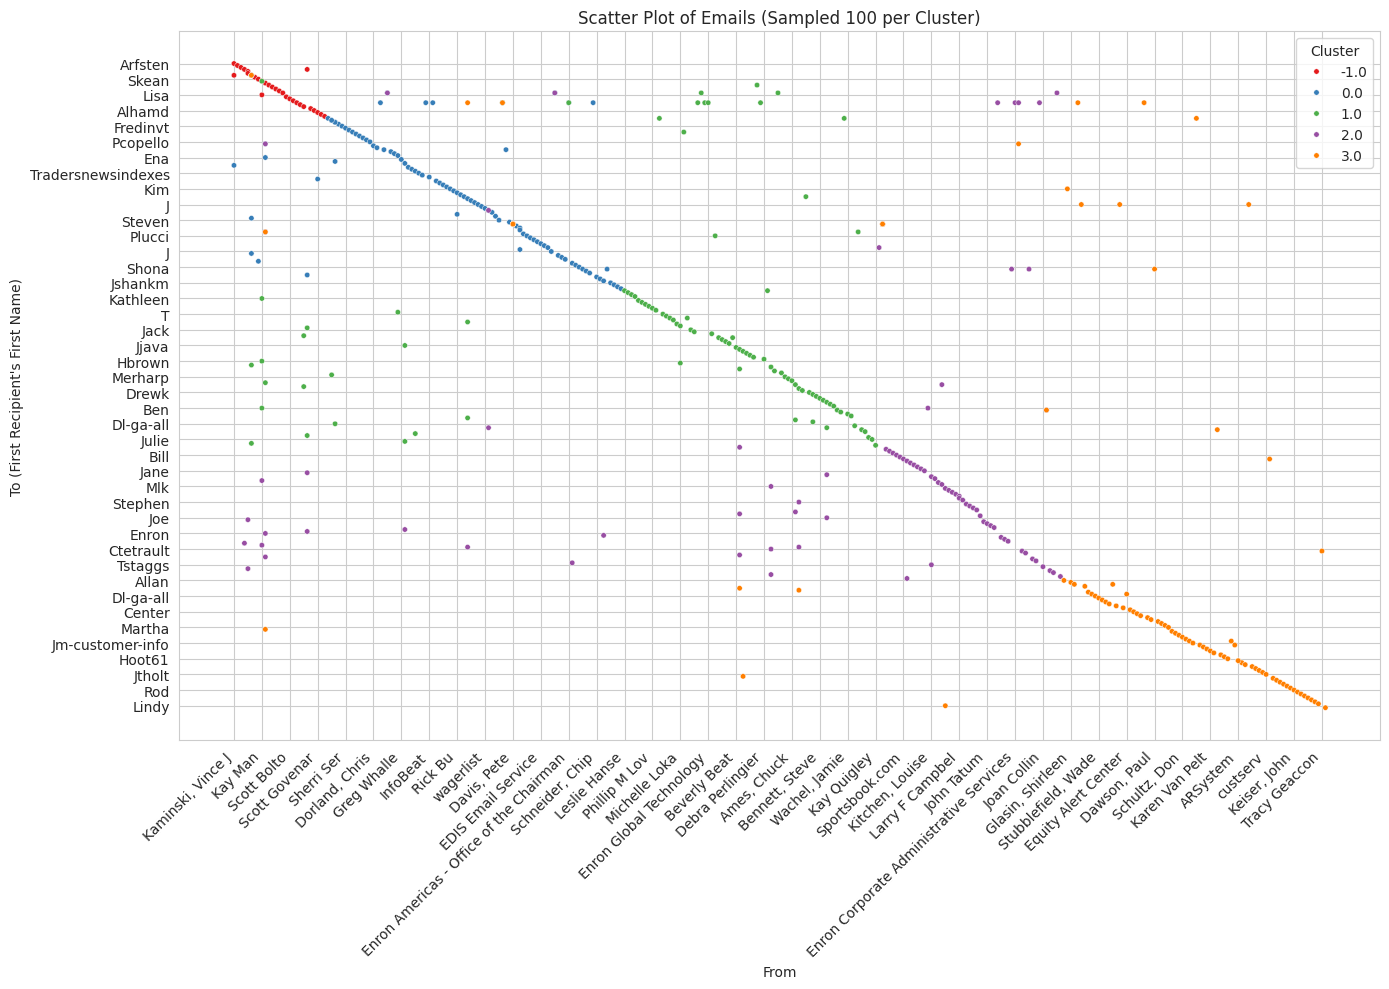

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample up to 100 points per cluster
sampled_df = emailsdf.groupby('cluster_k10').apply(
    lambda x: x.sample(n=min(100, len(x)), random_state=42)
)
sampled_df.reset_index(drop=True, inplace=True)

# Set up larger figure
plt.figure(figsize=(14, 10))

# Plot scatter with improved palette
sns.scatterplot(
    data=sampled_df,
    x='From',
    y='To',
    hue='cluster_k10',
    palette='Set1',
    s=15
)

# Improve aesthetics
plt.xlabel("From")
plt.ylabel("To (First Recipient's First Name)")
plt.title("Scatter Plot of Emails (Sampled 100 per Cluster)")

# Keep only some x-ticks to avoid crowding
xticks = sampled_df['From'].unique()
N = 8
plt.xticks(
    ticks=range(0, len(xticks), N),
    labels=xticks[::N],
    rotation=45,
    ha='right'
)

# Extract first recipient’s first name for y-ticks — without adding a new column
def first_to(to_string):
    try:
        first_recipient = str(to_string).split(',')[0].strip()
        if '@' in first_recipient:
            name_part = first_recipient.split('@')[0]
            return name_part.split('.')[0].split('_')[0].capitalize()
        else:
            return first_recipient.split()[0].capitalize()
    except Exception:
        return "Unknown"

# Apply to y-axis tick labels
yticks = sampled_df['To'].unique()
plt.yticks(
    ticks=range(0, len(yticks), N),
    labels=[first_to(to) for to in yticks[::N]]
)

# Final layout
plt.legend(title="Cluster", loc='upper right')
plt.tight_layout()
plt.show();


> **With a manageable number of clusters, we can now systematically analyze the content of emails, including subjects, senders, and receivers. This structured approach allows forensic investigators to identify which clusters contain fraudulent emails and uncover potential culprits. By leveraging data-driven insights, financial fraud expertise can focus their efforts on high-risk groups and enhance fraud detection strategies.**